In [1]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

2022-01-05 07:34:57.529206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 07:34:57.529226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
model_name = "mobilenet_v2_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
image_size = (224,224)
batch_size = 16
data_dir = "rank_data"

In [4]:
def build_dataset(subset):
      return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=.20,
        subset=subset,
        label_mode="categorical",
        seed=123,
        image_size=image_size,
        batch_size=1)

In [6]:
train_ds    = build_dataset("training")
val_ds      = build_dataset("validation")

train_size  = train_ds.cardinality().numpy()
val_size    =   val_ds.cardinality().numpy()
class_names = tuple(train_ds.class_names)

Found 1339 files belonging to 14 classes.
Using 1072 files for training.
Found 1339 files belonging to 14 classes.
Using 267 files for validation.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

preprocessing_train = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0, 0.2),
    tf.keras.layers.RandomTranslation(0.2, 0),
    tf.keras.layers.RandomZoom(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.1),
])

preprocessing_val = tf.keras.Sequential([
    normalization_layer])

In [8]:
train_ds = train_ds.unbatch().batch(batch_size)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda images, labels:(preprocessing_train(images), labels))

val_ds = val_ds.unbatch().batch(batch_size)
val_ds = val_ds.map(lambda images, labels:(preprocessing_val(images), labels))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 14)                17934     
                                                                 
Total params: 2,275,918
Trainable params: 2,241,806
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [12]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size
hist = model.fit(
    train_ds,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10
67/67 [==============================] - 66s 929ms/step - loss: 2.0867 - accuracy: 0.4366 - val_loss: 1.8460 - val_accuracy: 0.4766
Epoch 2/10
67/67 [==============================] - 61s 913ms/step - loss: 1.4655 - accuracy: 0.6875 - val_loss: 1.2310 - val_accuracy: 0.7969
Epoch 3/10
67/67 [==============================] - 61s 912ms/step - loss: 1.1174 - accuracy: 0.8358 - val_loss: 0.9956 - val_accuracy: 0.8984
Epoch 4/10
67/67 [==============================] - 61s 915ms/step - loss: 0.9769 - accuracy: 0.8965 - val_loss: 0.9212 - val_accuracy: 0.9102
Epoch 5/10
67/67 [==============================] - 61s 916ms/step - loss: 0.8951 - accuracy: 0.9338 - val_loss: 0.8621 - val_accuracy: 0.9336
Epoch 6/10
67/67 [==============================] - 61s 912ms/step - loss: 0.8523 - accuracy: 0.9534 - val_loss: 0.8467 - val_accuracy: 0.9492
Epoch 7/10
67/67 [==============================] - 61s 914ms/step - loss: 0.8393 - accuracy: 0.9534 - val_loss: 0.8446 - val_accuracy: 0.9492

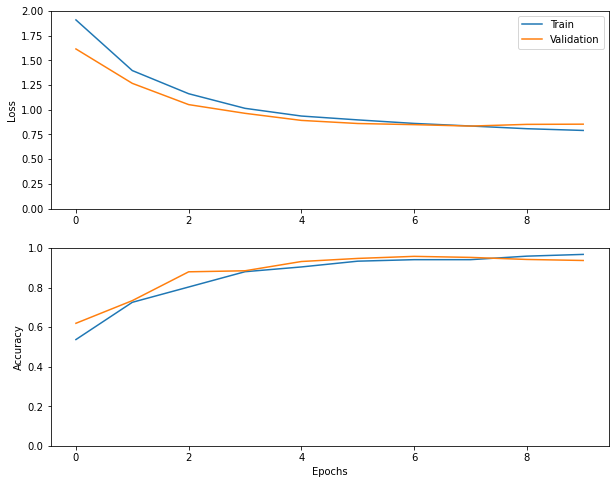

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.set(ylabel="Loss", ylim=[0,2])
ax1.plot(hist["loss"], label="Train")
ax1.plot(hist["val_loss"], label="Validation")
ax1.legend()

ax2.set(ylabel="Accuracy", xlabel="Epochs", ylim=[0,1])
ax2.plot(hist["accuracy"])
ax2.plot(hist["val_accuracy"])

fig.savefig("train_loss.png")

In [13]:
model.save("/home/woojac/proj/031_shuffle/rank_predictor03")

2022-01-05 07:49:23.639106: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/woojac/proj/031_shuffle/rank_predictor03/assets


INFO:tensorflow:Assets written to: /home/woojac/proj/031_shuffle/rank_predictor03/assets
